# Model Based Machine Learning Final Project

This notebook is designed for your Model Based Machine Learning final project.

## Getting Started

First, let's import the necessary libraries and load the dataset.

Tasks:
- Add a dataset section (General description and column values)
- Describe the different data types in the dataset (Categorical, Continuous, etc.) Noy)
- Correlation HeatMap (COMPLETED)
- Mutual Information (MI) analysis (COMPLETED)
- Histogram plot of the prices of cars (NOT YET.
- Different code cells for data transformations (Normalization, encoding categorical variables etc.)
- Make different PGM's - start with a basic linear regression model 
- a.r.d for assigning weights to input features to predict output (price)
- Data- and results analysis and comparison



In [73]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder


# Set up plotting
%matplotlib inline

# Hi

#Hi, how are you today

## Data Loading

Let's load the dataset for our analysis.

In [74]:
# Load the car price prediction dataset
data = pd.read_csv('car_price_prediction.csv')

# Display the first few rows of the dataset
data.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [75]:
print("Dataset shape: ", data.shape)
print(data.columns)

Dataset shape:  (19237, 18)
Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year',
       'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')


## Data Exploration

Now let's examine the dataset to understand its structure and contents.

In [76]:
# Check the shape of the dataset
print(f"Dataset shape: {data.shape}")
# Get the column information
print("\nColumn information:")
data.info()




Dataset shape: (19237, 18)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  objec

In [77]:
# Get statistical summary of the data
data.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


## Data Visualization

Let's create some visualizations to better understand the data.

In [78]:
# Do data visualization tasks here...

# Data transformation

Let's transform some of the data columns before analyzing.



In [79]:
# Drop ID column
data.drop(columns=['ID'], inplace=True)

# Clean 'Levy': replace '-' with 0 and convert to int

data['Levy'] = data['Levy'].replace('-', '0').astype(int)

# Clean 'Mileage': remove ' km' and convert to int
data['Mileage'] = data['Mileage'].str.replace(' km', '').astype(int)

# Clean 'Engine volume': remove ' Turbo' and convert to float
data['Engine volume'] = data['Engine volume'].str.replace(' Turbo', '')
data['Engine volume'] = data['Engine volume'].astype(float)

# Clean 'Doors': fix weird values and convert to float
data['Doors'] = data['Doors'].replace({
    '04-May': '4', '02-Mar': '2', '>5': '5'
})
data['Doors'] = pd.to_numeric(data['Doors'], errors='coerce')

# Encode all categorical variables using LabelEncoder
for col in data.select_dtypes(include='object').columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Drop rows with NaN values (if any)
data.dropna(inplace=True)


# Data analysis

Let's do some data analysis to get a better idea of the distribution of the data and the correlation.

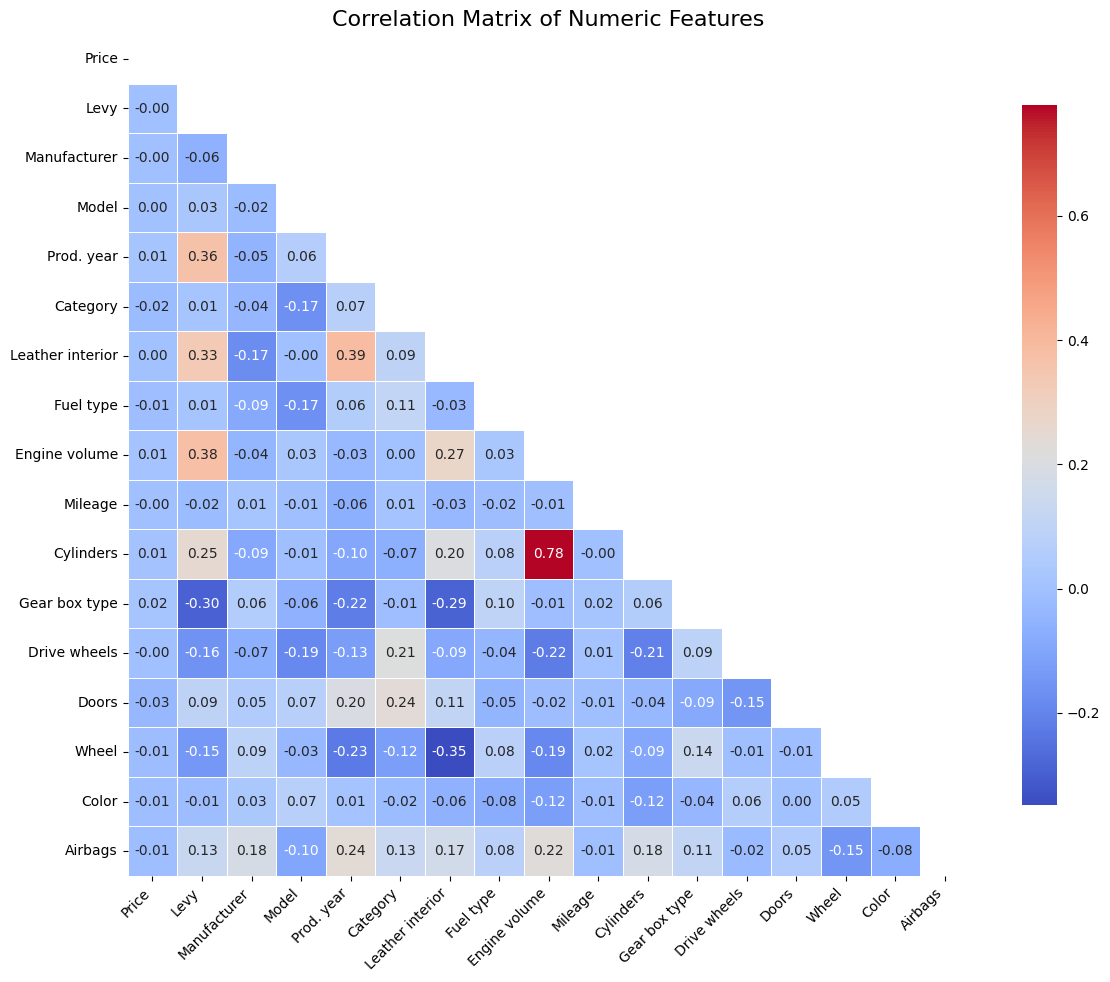

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select only numeric columns for correlation analysis
numeric_data = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr = numeric_data.corr()

# Create a mask for the upper triangle (optional but makes it cleaner)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True,
    annot_kws={"size": 10},
)

# Improve layout and readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()


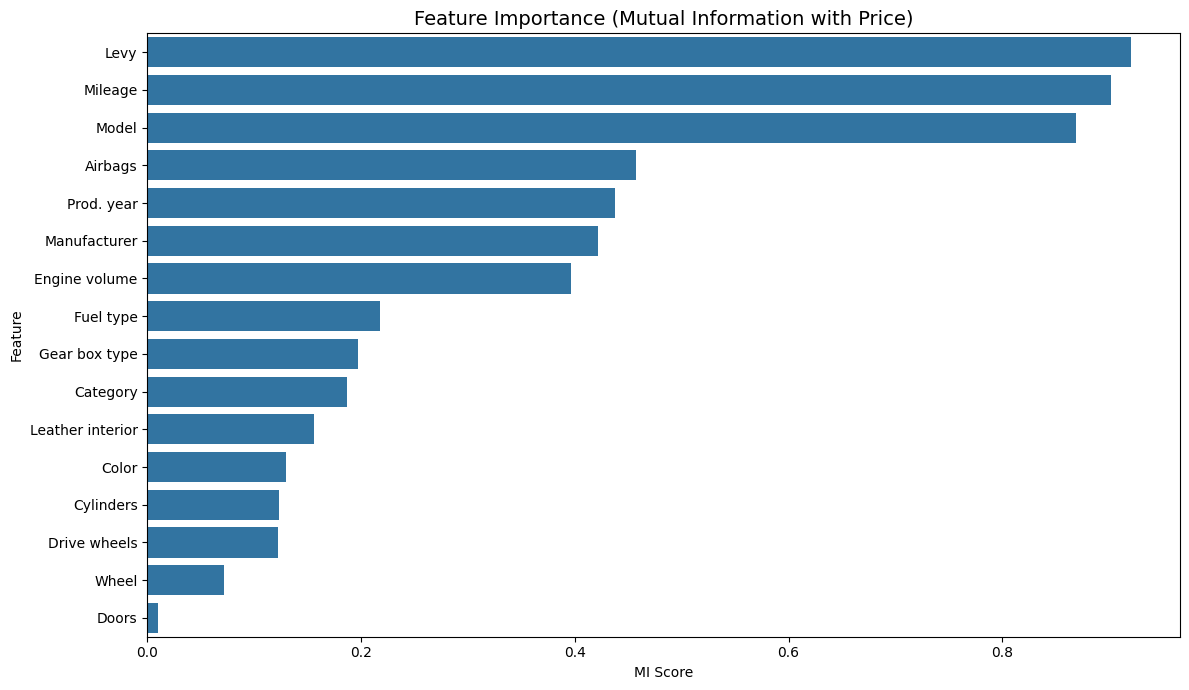

In [82]:

# Features and target
X = data.drop(columns=['Price'])
y = data['Price']

# Compute mutual information
mi_scores = mutual_info_regression(X, y, discrete_features='auto')
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Feature Importance (Mutual Information with Price)", fontsize=14)
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Feature Engineering

Based on our analysis, let's prepare the features for modeling.

In [ ]:
# TODO: Add your feature engineering code here
# For example, handling missing values, creating new features, etc.
# I did some feature engineering above to get a better idea of the mutual information about the inputs and the target variable (price).



## Model Development

Now let's develop machine learning models for our task.

In [ ]:
# TODO: Add your model development code here
# For example:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score

## Model Evaluation

Let's evaluate our models and compare their performance.

In [ ]:
# TODO: Add your model evaluation code here

## Conclusion

Summarize your findings and conclusions from the analysis.

In [ ]:
# Add any final analyses or visualizations here